## Random Forest Regressor from Scratch

### Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
from sklearn.metrics import mean_squared_error    ## For evaluation only

### Loading Data Set

In [2]:
# loading dataset
def getData(strt_date = "2019-01-01", end_date = "2019-12-31"):
    
    FF = pd.read_csv("C:\\Users\\sshai\\Desktop\\Northeastern University\\INFO 7374 ML In Finance\\INFO-7374-Machine-Learning-in-Finance\\Dashboard\\Shaishav\\fulldata.csv")
    # Date format change
    FF["Date"] = pd.to_datetime(FF["Date"])
    # Data selection
    df = FF[(FF["Date"] >= strt_date) & (FF["Date"] <= end_date)]
    # Reset Index
    df = df.reset_index()
    df = df.drop(["index"], axis =1)
    # Average Column and no. of days calculations
    df["Average"] = (FF["Open"] + 2*FF["High"] + FF["Close"])/4
    df["Days"] = range(1,df.shape[0]+1)
    df["delta_Open"] = (df.Open - df.Open.shift(periods=1))
    df["delta_Close"] = (df.Close - df.Close.shift(periods=1))
    df["delta_RMW"] = (df.RMW - df.RMW.shift(periods=1))
    df["delta_SMB"] = (df.SMB - df.SMB.shift(periods=1))
    df["delta_MktRF"] = (df["Mkt-RF"] - df["Mkt-RF"].shift(periods=1))
    df["delta_HML"] = (df.HML - df.HML.shift(periods=1))
    df["delta_CMA"] = (df.CMA - df.CMA.shift(periods=1))
    df["delta_Average"] = (df.Average - df.Average.shift(periods=1))
    df = df.dropna().reset_index(drop=True)
    
    df["label"] = df.delta_Open
    df = df.drop("delta_Open", axis=1)
    
    return df

In [3]:
## One year data
df = getData()

## Removing correlated columns
df.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Mkt-RF',
       'SMB', 'HML', 'RMW', 'CMA', 'RF', ' HC- Open', ' HC- High', ' HC- Low',
       ' HC- Close', 'S&P 500-Open', 'S&P500-High', 'S&P-Low', 'S&P-Close',
       'S&P500-Adj Close', 'S&P500-Volume', 'ADS-Index', 'Average', 'Days',
       'delta_Close', 'delta_RMW', 'delta_SMB', 'delta_MktRF', 'delta_HML',
       'delta_CMA', 'delta_Average', 'label'],
      dtype='object')

### Data Modification

In [4]:
df_x = df.drop("label", axis =1).shift(periods=1).dropna().reset_index(drop=True)
df_y = df[["label"]].shift(periods=-1).dropna().reset_index(drop=True)
modified_df = pd.concat([df_x,df_y], axis =1)

modified_df

,Date,High,Low,Open,Close,Volume,Adj Close,Mkt-RF,SMB,HML,...,Average,Days,delta_Close,delta_RMW,delta_SMB,delta_MktRF,delta_HML,delta_CMA,delta_Average,label
0,2019-01-03,92.500000,90.379997,90.940002,90.639999,9820200.0,87.639870,-2.45,0.52,1.23,...,53.531250,2.0,-0.639999,-0.12,-0.21,-2.68,0.08,0.65,-0.328125,-0.100006
1,2019-01-04,92.489998,90.370003,90.839996,92.489998,10565700.0,89.428635,3.55,0.39,-0.74,...,52.343750,3.0,1.849998,0.16,-0.13,6.00,-1.97,-1.49,-1.187500,1.070007
2,2019-01-07,92.500000,91.400002,91.910004,92.120003,9012500.0,89.070892,0.94,0.82,-0.67,...,53.984375,4.0,-0.369995,-0.61,0.43,-2.61,0.07,0.17,1.640625,0.789993
3,2019-01-08,93.089996,91.820000,92.699997,92.459999,9551300.0,89.399635,1.01,0.44,-0.53,...,57.507812,5.0,0.339996,1.05,-0.38,0.07,0.14,0.32,3.523438,-0.009995
4,2019-01-09,92.959999,90.809998,92.690002,90.949997,15015600.0,87.939613,0.56,0.51,-0.04,...,58.296875,6.0,-1.510002,-0.26,0.07,-0.45,0.49,-0.09,0.789062,-1.800003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2019-12-20,126.599999,125.029999,126.150001,125.360001,16250500.0,124.619614,0.48,-0.27,-0.29,...,36.867188,246.0,0.440002,0.24,-0.14,0.05,0.14,-0.03,-0.046875,-0.630005
245,2019-12-23,125.820000,124.690002,125.519997,124.900001,6619500.0,124.162331,0.10,0.16,-0.28,...,37.101562,247.0,-0.459999,-0.15,0.43,-0.38,0.01,0.37,0.234375,-0.729996
246,2019-12-24,125.309998,124.580002,124.790001,125.220001,2022100.0,124.480438,0.01,0.36,-0.07,...,37.156250,248.0,0.320000,-0.16,0.20,-0.09,0.21,-0.29,0.054688,0.309998
247,2019-12-26,125.750000,124.870003,125.099999,125.220001,4760400.0,124.480438,0.49,-0.56,0.00,...,37.203125,249.0,0.000000,0.51,-0.92,0.48,0.07,-0.21,0.046875,0.459999


### Test/ Train Data set

In [5]:
## Train and Test Data
train_start_date = "2019-01-01"
train_end_date =  "2019-10-31"
test_start_date = "2019-11-01"
test_end_date = "2019-12-31"
df_tr = df[(df["Date"] >= train_start_date) & (df["Date"] <= train_end_date)]
df_tst = df[(df["Date"] >= test_start_date) & (df["Date"] <= test_end_date)]
df_train = df_tr[["Open","Volume","RF","delta_Close","delta_RMW","delta_SMB","delta_MktRF","delta_HML","delta_CMA","delta_Average","label"]]
df_test = df_tst[["Open","Volume","RF","delta_Close","delta_RMW","delta_SMB","delta_MktRF","delta_HML","delta_CMA","delta_Average","label"]]

In [6]:
df_train.head()

,Open,Volume,RF,delta_Close,delta_RMW,delta_SMB,delta_MktRF,delta_HML,delta_CMA,delta_Average,label
0,90.940002,9820200.0,0.01,-0.639999,-0.12,-0.21,-2.68,0.08,0.65,-0.328125,-0.089996
1,90.839996,10565700.0,0.01,1.849998,0.16,-0.13,6.00,-1.97,-1.49,-1.187500,-0.100006
2,91.910004,9012500.0,0.01,-0.369995,-0.61,0.43,-2.61,0.07,0.17,1.640625,1.070007
3,92.699997,9551300.0,0.01,0.339996,1.05,-0.38,0.07,0.14,0.32,3.523438,0.789993
4,92.690002,15015600.0,0.01,-1.510002,-0.26,0.07,-0.45,0.49,-0.09,0.789062,-0.009995


In [7]:
df_test.head()

,Open,Volume,RF,delta_Close,delta_RMW,delta_SMB,delta_MktRF,delta_HML,delta_CMA,delta_Average,label
210,124.830002,6010100.0,0.006,-0.639999,-0.01,0.93,1.46,1.26,-0.04,-1.867188,0.040001
211,123.919998,10351400.0,0.006,-4.800003,0.83,-0.26,-0.68,0.61,0.00,-0.789062,-0.910004
212,118.830002,9239600.0,0.006,-0.169998,-0.62,0.06,-0.43,-0.98,-0.12,-0.257812,-5.089996
213,119.099999,6755900.0,0.006,1.419998,-0.16,-1.19,-0.02,-0.33,0.29,0.171875,0.269997
214,120.339996,8909700.0,0.006,-0.699997,0.36,0.81,0.43,0.41,-0.40,0.085938,1.239998


### Helper Functions

#### Check Purity?

In [8]:
def check_purity(data):
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)
    if len(unique_classes) == 1:
        return True
    else:
        return False

#### Check leaf for regressor

In [9]:
def create_leaf(data):
    label_column = data[:, -1]
    leaf = np.mean(label_column)
    return leaf

#### Number of potential split

In [10]:
def get_potential_splits(data, random_subspace):
    
    potential_splits = {}
    _, n_columns = data.shape
    
    column_indices = list(range(n_columns-1))       # excluding the last column which is the label
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)
    
    for column_index in column_indices:          
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
        
    return potential_splits

#### Split Data

In [11]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

#### Calculate best split

In [12]:
def calculate_mse(data):
    
    actual_values = data[:, -1]
    if len(actual_values) == 0:   # empty data
        mse = 0
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    
    return mse

In [13]:
def calculate_overall_metric(data_below, data_above, metric_function):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric =  (p_data_below * metric_function(data_below) 
                     + p_data_above * metric_function(data_above))
    
    return overall_metric


In [14]:
def determine_best_split(data, potential_splits):
    
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_mse)

            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

#### Determine Type of Feature

In [15]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

#### Bootstrapping

In [16]:
def bootstrapping(train_df, n_bootstrap):
    
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    
    return df_bootstrapped

### Decision Tree Algorithm for Regressor

In [17]:
def decision_tree_algorithm(df, counter=0, min_samples=5, max_depth=5, random_subspace=None):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data)
        return leaf

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data)
            return leaf
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)
        
        # If yes_answer = no_answer
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

### Random Forest Alogorithm for Regressor

In [18]:
def random_forest_algorithm(df_train, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(df_train, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
    
    return forest

### Predictions

In [19]:
def predict_example(example, tree):
    record = list()
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [20]:
def decision_tree_predictions(df_test, tree):
    predictions = df_test.apply(predict_example, args=(tree,), axis=1)
    return predictions

In [21]:
def random_forest_predictions(df_test, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(df_test, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions

### Evaluation

In [22]:
def calculate_r_squared(predictions, labels):    
    mean = labels.mean()
    ss_res = sum((labels - predictions) ** 2)
    ss_tot = sum((labels - mean) ** 2)
    r_squared = 1 - ss_res / ss_tot
    
    return r_squared

In [23]:
def calculate_rmse(predictions, labels):
    mse = mean_squared_error(labels,predictions)
    rmse = np.sqrt(mse)
    return rmse

### Visualisation Functions

In [24]:
def create_plot(predictions, labels, title):    
    plot_df = pd.DataFrame({"actual": labels, "predictions": predictions})
    plot_df.plot(figsize=(18, 5), title=title)
    
    return

### Hyperparameter Tuning

In [25]:
grid_search = {"max_depth": [], "trees": [], "rmse_test": [], "r_squared_test": [], "bootstrap": [] }
for max_depth in range(1, 7):
    for trees in range(1,10):
        for bootstrap in range(25,225,25):
            forest = random_forest_algorithm(df_train, n_trees=trees, n_bootstrap= bootstrap, n_features=3, dt_max_depth=max_depth)
            delta_Open_pred = random_forest_predictions(df_test, forest)
            df_pred = pd.DataFrame(list(zip(delta_Open_pred,df_test.label.values, df_test.Open.values)), columns = ["predictions","Actual","Open_Act"])
            df_pred["Open_pred"] = df_pred.predictions + df_test.Open.shift(1).reset_index(drop=True)
            df_pred = df_pred.dropna().reset_index(drop=True)

            rmse_test = calculate_rmse(list(df_pred.Open_pred.values), list(df_pred.Open_Act.values))
            r_squared_test = calculate_r_squared(df_pred.Open_pred, df_pred.Open_Act)

            grid_search["max_depth"].append(max_depth)
            grid_search["trees"].append(trees)
            grid_search["bootstrap"].append(bootstrap)
            grid_search["rmse_test"].append(rmse_test)
            grid_search["r_squared_test"].append(r_squared_test)
        
    print(f"Progress: Iteration {max_depth}/6")
        
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("r_squared_test", ascending=False).head()

Progress: Iteration 1/6
Progress: Iteration 2/6
Progress: Iteration 3/6
Progress: Iteration 4/6
Progress: Iteration 5/6
Progress: Iteration 6/6


,max_depth,trees,rmse_test,r_squared_test,bootstrap
85,2,2,1.062469,0.779252,150
110,2,5,1.089586,0.767840,175
196,3,7,1.096662,0.764815,125
255,4,5,1.099511,0.763591,200
35,1,5,1.101455,0.762755,100


### Best Possible Solution

In [33]:

forest = random_forest_algorithm(df_train, n_trees=2, n_bootstrap= 150, n_features=3, dt_max_depth=2)
delta_Open_pred = random_forest_predictions(df_test, forest)
df_pred = pd.DataFrame(list(zip(delta_Open_pred,df_test.label.values, df_test.Open.values)), columns = ["predictions","Actual","Open_Act"])
df_pred["Open_pred"] = df_pred.predictions + df_test.Open.shift(1).reset_index(drop=True)
df_pred = df_pred.dropna().reset_index(drop=True)

rmse_test = calculate_rmse(list(df_pred.Open_pred.values), list(df_pred.Open_Act.values))
r_squared_test = calculate_r_squared(df_pred.Open_pred, df_pred.Open_Act)
  
print("RMSE value of best possible solution: ",rmse_test)
print("R2 value of best possible solution: ",r_squared_test)    

RMSE value of best possible solution:  0.9653342535370901
R2 value of best possible solution:  0.8177700212603203


## Visualization

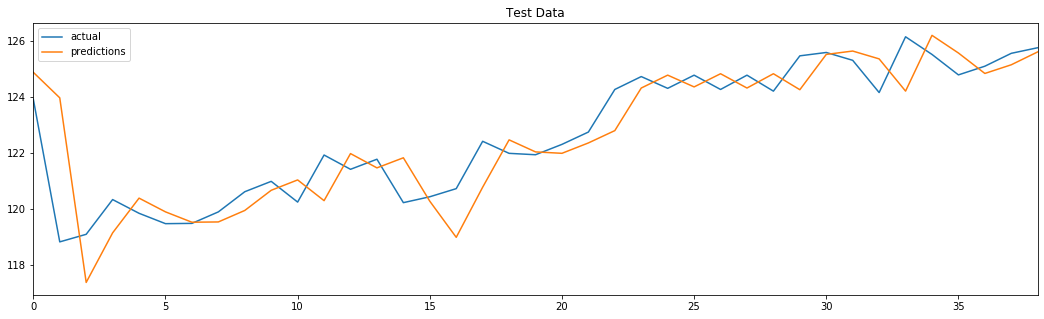

In [27]:
create_plot(list(df_pred.Open_pred.values), list(df_pred.Open_Act.values), title="Test Data")

## Back Testing

In [34]:
def backtesting_df(main_data, pred_data):
    backtesting_df = pd.concat([main_data[["Date","Open","Close","S&P 500-Open","S&P-Close","High"]].reset_index(drop=True),pred_data["Open_pred"]], axis=1)
    backtesting_df = backtesting_df.rename(columns={"Date": "Date", "Open": "R_Open", "High": "R_High", "Close": "R_Close","S&P 500-Open": "SP_Open","S&P-Close": "SP_Close","Open_pred": "P_Open"})
    
    return backtesting_df

In [35]:
def back_test(df_backtest):
    df = df_backtest.copy()
    conditions = [(df['P_Open'].shift(-1) > df['R_Open'].shift(-1)) & (df['P_Open'].shift(-1) < df['R_High'].shift(-1)),
                  (df['P_Open'].shift(-1) > df['R_Open'].shift(-1)) & (df['P_Open'].shift(-1) > df['R_High'].shift(-1))]
    choices = [(df['P_Open'].shift(-1) - df['R_Close'])*100/df['R_Close'], 
               (df['R_High'].shift(-1) - df['R_Close'])*100/df['R_Close']]
    #Ra : Portfolio's Return
    df['Ra'] = np.where(df['P_Open'].shift(-1) > df['R_Close'],                          
                              np.select(conditions, choices, default=np.nan),
                              np.nan)
    #Riskfree return (S&P500 return)
    df['Rb'] = np.where(df['P_Open'].shift(-1) > df['R_Close'],                          
                              (df['SP_Open'].shift(-1) - df['SP_Close'])*100/df['SP_Close'],
                              np.nan)
    df = df.dropna()
    #Sharpe ratio
    Sharpe = (df['Ra'] - df['Rb']).mean() / (df['Ra'] - df['Rb']).std()
    beta = ((df[['Ra','Rb']]).cov()).Rb[0] / df['Rb'].var()
    #Treynor ratio
    Treynor  = (df['Ra'] - df['Rb']).mean() / beta    
    #average profit
    profit = df['Ra'].mean()
    #hitrate
    Hitrate = df[df['Ra'] > 0]['Ra'].count() / df['Ra'].count()
    
    return Sharpe, Treynor, profit, Hitrate

In [37]:
back_test_df = backtesting_df(df_tst, df_pred)
[sharpe_ratio, treynor_ratio, avg_profit, hitrate] = back_test(back_test_df)

print("Backtesting results are given below: ")
print(" 1. Sharpe Ratio is: ", round(sharpe_ratio,2))
print(" 2. Treynor Ratio is: ", round(treynor_ratio,2))
print(" 3. Average Profit is: ", round(avg_profit,2), "BPS")
print(" 4. Hit Rate is: ", round(hitrate,2))

Backtesting results are given below: 
 1. Sharpe Ratio is:  0.55
 2. Treynor Ratio is:  0.78
 3. Average Profit is:  0.28 BPS
 4. Hit Rate is:  0.95
